In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [62]:
# loading the dataset

# since no columns are there in the dataset
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]

train_df = pd.read_csv("FCNN_Lab1_dataset/adult.data",names = columns, sep = ', *', engine='python')
test_df = pd.read_csv('FCNN_Lab1_dataset/adult.test', names=columns, sep=', *', engine='python', skiprows=1)

train_df['income'] = train_df['income'].str.replace('.', '', regex=False).str.strip()
test_df['income'] = test_df['income'].str.replace('.', '', regex=False).str.strip()

In [63]:
#dealing with NA values, by filling with Mode

columns_with_na = train_df.columns[train_df.isnull().any()].tolist()

for col in columns_with_na:
    mode_value = train_df[col].mode()[0]
    train_df[col] = train_df[col].fillna(mode_value)
    test_df[col] = test_df[col].fillna(mode_value)

#now separating the output from the input features, in both train and test sets
#train sets
x_t_r = train_df.drop("income",axis=1)
y_t_r = train_df["income"].map({"<=50K":0, ">50K":1})

#test sets
x_te_r = test_df.drop("income",axis =1)
y_te_r = test_df["income"].map({"<=50K":0, ">50K":1})

#one hot encoding
x_train = pd.get_dummies(x_t_r)
x_test = pd.get_dummies(x_te_r)

#handling the case in which if the test set doesnt have a particular feature value the one hot encoded vector wont be aligned with the training data in whihch the particular extra feature did appear.

x_train, x_test = x_train.align(x_test,join='left', axis=1, fill_value=0) # fill in the left values as 0


Class Percentage:
income
0    75.919044
1    24.080956
Name: proportion, dtype: float64


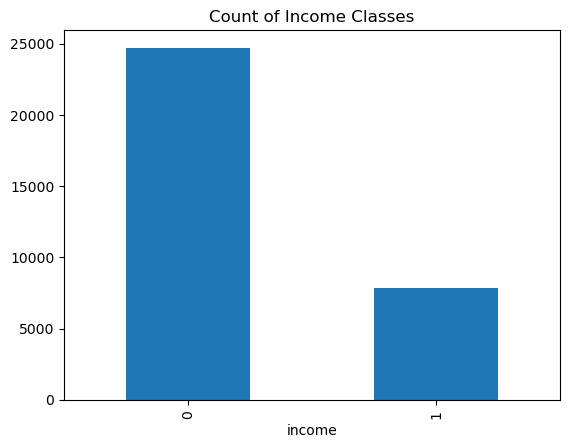

In [64]:
print("\nClass Percentage:")
print(y_t_r.value_counts(normalize=True) * 100)

y_t_r.value_counts().plot(kind='bar', title='Count of Income Classes')
plt.show()

In [65]:
#converting to np

x_train = x_train.values.astype(np.float32)
y_train = y_t_r.values.astype(np.float32).reshape(-1,1) # reshaping the 1-D vector to a 2-D vector so to calculate the loss yi for each input xi

x_test = x_test.values.astype(np.float32)
y_test = y_te_r.values.astype(np.float32).reshape(-1,1)
print(x_train.shape) # gives the number of input neurons required, here 108 are required



(32561, 108)


## **FCNN implementation**

1. total neurons in input layer = 108 
2. total neurons in 1st hidden layer = 65, total neurons in second hidden layer = 33
3. total neurons in output layer = 1
4. total weights in 1st layer = 108*65 = 7020 + 65 biases = 7085 in layer 1->2
5. total weights and biases in 2nd layer = 65*33 + 33 biases = 2178 in layer 2->3
6. total weights and biases in layer 3-> output = 34
7. total parameters to tune = 9297

In [66]:
def forward_pass(x,theta): # relu for hidden and sigmoid for output
    A1 = np.dot(x,theta["w1"]) + theta["b1"]
    H1 = np.maximum(0,A1) #ReLU activation

    A2 = np.dot(H1,theta["w2"]) + theta["b2"]
    H2 = np.maximum(0,A2)

    A3 = np.dot(H2,theta["w3"]) + theta["b3"]
    A3_clipped = np.clip(A3, -500, 500)
    H3 = 1 / (1 + np.exp(-A3_clipped))

    cache = {"A1":A1, "H1":H1, "A2":A2, "H2":H2, "A3":A3, "H3":H3}
    return cache


In [67]:
def backpropagation(x,y,cache,theta):
    # compute the derivative of loss fn wrt output unit (y_exp (is just H3) then aL), the required loss function is the cross-entropy loss
    dA3 = cache["H3"] - y
    # now we compute the grad wrt w3 and b3 (before out layer)
    m = x.shape[0]
    dw3 = (1/m)*(np.dot(cache["H2"].T,dA3))
    db3 = (1/m)*np.sum(dA3, axis=0, keepdims=True)

    dH2 = np.dot(dA3,theta["w3"].T)
    dA2 = np.array(dH2, copy=True)
    dA2[cache["A2"] <= 0] = 0 # if the contribution is less than 0 deriv is 0 other wise 1 so 1*dh2

    dw2 = (1/m)*(np.dot(cache["H1"].T,dA2))
    db2 = (1/m)*np.sum(dA2, axis=0, keepdims=True)

    dH1 = np.dot(dA2,theta["w2"].T)
    dA1 = np.array(dH1, copy=True)
    dA1[cache["A1"] <= 0] = 0

    dw1 = (1/m)*(np.dot(x.T,dA1))
    db1 = (1/m)*np.sum(dA1, axis=0, keepdims=True)

    grad = {"dw1": dw1, "db1": db1,
    "dw2": dw2, "db2": db2,
    "dw3": dw3, "db3": db3}
    return grad

In [68]:
def update(theta, grad, neta = 0.01):
    theta["w1"] -= neta * grad["dw1"]
    theta["b1"] -= neta * grad["db1"]
    
    theta["w2"] -= neta * grad["dw2"]
    theta["b2"] -= neta * grad["db2"]
    
    theta["w3"] -= neta * grad["dw3"]
    theta["b3"] -= neta * grad["db3"]
    
    return theta

In [69]:
def Loss_calc(y,H3): #calculate the cross entropy loss (as we are focusing on binary classification)
    m = y.shape[0] #total samples
    corr = 1e-8
    H3 = np.clip(H3, corr, 1 - corr) # avoiding the log(0) and log(1) cases
    
    # bin Cross entropy loss
    loss = - (1/m)*np.sum(y * np.log(H3) + 3*(1 - y)*np.log(1 - H3))
    return loss

In [70]:
def SGD(ep):
    loss_history = []
    acc_history = []
    iter_history = []
    # layer 1 
    w1 = np.random.randn(108,65)*np.sqrt(2/108) #He-initialization of weights
    b1 = np.zeros((1,65))
    # layer 2
    w2 = np.random.randn(65,33)*np.sqrt(2/65)
    b2 = np.zeros((1,33)) 
    # layer 3
    w3 = np.random.randn(33,1)*np.sqrt(2/33) 
    b3 = np.zeros((1,1))
    # applying the forwardPass algorithm with backprop for learning the weights
    theta = {"w1":w1, "b1":b1, "w2":w2, "b2":b2, "w3":w3, "b3":b3}
    iter = 0
    neta = 0.01
    for epoch in range(ep): # outer loop for training different epochs, to stop the network from memorising the training data
        ind = np.arange(x_train.shape[0])
        np.random.shuffle(ind)
        x_shf = x_train[ind]
        y_shf = y_train[ind]
        # inner loop for minibatch grad descent
        for i in range(0,x_shf.shape[0],128):
            x_b = x_shf[i:i+128]
            y_b = y_shf[i:i+128]

            cache = forward_pass(x_b,theta) #cache is the activations + pre-activations
            grad = backpropagation(x_b, y_b, cache, theta)
            theta = update(theta,grad,neta)
            if iter%100 == 0:
            # Calculate current loss on the current batch
                current_loss = Loss_calc(y_b, cache['H3'])
                loss_history.append(current_loss)
                iter_history.append(iter)
                print(f"Iteration {iter} | Loss: {current_loss:.3f}")
            iter += 1
        # epoch-end accuracy
        cache_test = forward_pass(x_test, theta)
        preds = (cache_test["H3"] > 0.5).astype(int)
        acc = np.mean(preds == y_test)
        acc_history.append(acc)
        neta = neta*0.97
    return theta, loss_history, acc_history, iter_history

In [71]:
# main

theta, loss_raw, acc_raw, iter_hist_raw = SGD(50)
def evaluate_metrics(x_test, y_test, theta):
    # 1. Get predictions
    cache = forward_pass(x_test, theta)
    # Convert probabilities to binary 0 or 1
    predictions = (cache["H3"] > 0.5).astype(int)
    
    # 2. Basic Accuracy
    accuracy = np.mean(predictions == y_test) * 100
    tp = np.sum((predictions == 1) & (y_test == 1))
    
    tn = np.sum((predictions == 0) & (y_test == 0))
    fp = np.sum((predictions == 1) & (y_test == 0))
    fn = np.sum((predictions == 0) & (y_test == 1))
    
    precision = tp / (tp + fp + 1e-15) 
    recall = tp / (tp + fn + 1e-15)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-15)
    
    # Print a clean report
    print("--- Model Performance Report ---")
    print(f"Accuracy:  {accuracy:.2f}%")
    print(f"Precision: {precision:.4f} (How many predicted high-earners actually are)")
    print(f"Recall:    {recall:.4f} (How many actual high-earners were caught)")
    print(f"F1-Score:  {f1_score:.4f} (Balanced harmonic mean)")
    print("--------------------------------")
    
    return {"acc": accuracy, "p": precision, "r": recall, "f1": f1_score}

# Usage:
results = evaluate_metrics(x_test, y_test, theta)

Iteration 0 | Loss: 3.598
Iteration 100 | Loss: 1.554
Iteration 200 | Loss: 1.390
Iteration 300 | Loss: 1.292
Iteration 400 | Loss: 1.222
Iteration 500 | Loss: 1.157
Iteration 600 | Loss: 1.116
Iteration 700 | Loss: 1.094
Iteration 800 | Loss: 1.070
Iteration 900 | Loss: 1.044
Iteration 1000 | Loss: 1.042
Iteration 1100 | Loss: 1.021
Iteration 1200 | Loss: 1.036
Iteration 1300 | Loss: 0.982
Iteration 1400 | Loss: 1.000
Iteration 1500 | Loss: 0.995
Iteration 1600 | Loss: 0.982
Iteration 1700 | Loss: 1.008
Iteration 1800 | Loss: 1.005
Iteration 1900 | Loss: 0.969
Iteration 2000 | Loss: 1.035
Iteration 2100 | Loss: 0.960
Iteration 2200 | Loss: 0.975
Iteration 2300 | Loss: 0.962
Iteration 2400 | Loss: 0.963
Iteration 2500 | Loss: 0.968
Iteration 2600 | Loss: 0.986
Iteration 2700 | Loss: 0.962
Iteration 2800 | Loss: 0.962
Iteration 2900 | Loss: 0.993
Iteration 3000 | Loss: 0.956
Iteration 3100 | Loss: 0.988
Iteration 3200 | Loss: 0.991
Iteration 3300 | Loss: 0.983
Iteration 3400 | Loss: 0.9

In [72]:
def min_max_scaling(df):
    # Identify numerical columns (exclude one-hot encoded ones)
    num_cols = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
    
    # Apply Min-Max formula: (x - min) / (max - min) 
    for col in num_cols:
        col_min = df[col].min()
        col_max = df[col].max()
        df[col] = (df[col] - col_min) / (col_max - col_min)
    return df

num_cols = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

mins = x_t_r[num_cols].min()
maxs = x_t_r[num_cols].max()

x_t_r_scaled[num_cols] = (x_t_r[num_cols] - mins) / (maxs - mins)
x_te_r_scaled[num_cols] = (x_te_r[num_cols] - mins) / (maxs - mins)

x_train_scaled = pd.get_dummies(x_t_r_scaled)
x_test_scaled = pd.get_dummies(x_te_r_scaled)
x_train_scaled, x_test_scaled = x_train_scaled.align(x_test_scaled, join='left', axis=1, fill_value=0)

x_train = x_train_scaled.values.astype(np.float32)
x_test = x_test_scaled.values.astype(np.float32)
theta_scaled, loss_scaled, acc_scaled, iter_hist_scaled = SGD(50)

print("--- Results with Min-Max Scaling ---")
evaluate_metrics(x_test, y_test, theta_scaled)

Iteration 0 | Loss: 1.964
Iteration 100 | Loss: 1.076
Iteration 200 | Loss: 0.920
Iteration 300 | Loss: 0.914
Iteration 400 | Loss: 0.848
Iteration 500 | Loss: 0.757
Iteration 600 | Loss: 0.794
Iteration 700 | Loss: 0.907
Iteration 800 | Loss: 0.745
Iteration 900 | Loss: 0.742
Iteration 1000 | Loss: 0.656
Iteration 1100 | Loss: 0.601
Iteration 1200 | Loss: 0.788
Iteration 1300 | Loss: 0.750
Iteration 1400 | Loss: 0.722
Iteration 1500 | Loss: 0.715
Iteration 1600 | Loss: 0.624
Iteration 1700 | Loss: 0.744
Iteration 1800 | Loss: 0.664
Iteration 1900 | Loss: 0.645
Iteration 2000 | Loss: 0.718
Iteration 2100 | Loss: 0.785
Iteration 2200 | Loss: 0.705
Iteration 2300 | Loss: 0.731
Iteration 2400 | Loss: 0.673
Iteration 2500 | Loss: 0.631
Iteration 2600 | Loss: 0.722
Iteration 2700 | Loss: 0.646
Iteration 2800 | Loss: 0.646
Iteration 2900 | Loss: 0.665
Iteration 3000 | Loss: 0.557
Iteration 3100 | Loss: 0.773
Iteration 3200 | Loss: 0.684
Iteration 3300 | Loss: 0.695
Iteration 3400 | Loss: 0.6

{'acc': 84.33142927338616,
 'p': 0.7112561174551386,
 'r': 0.5668226729069162,
 'f1': 0.6308783099406737}

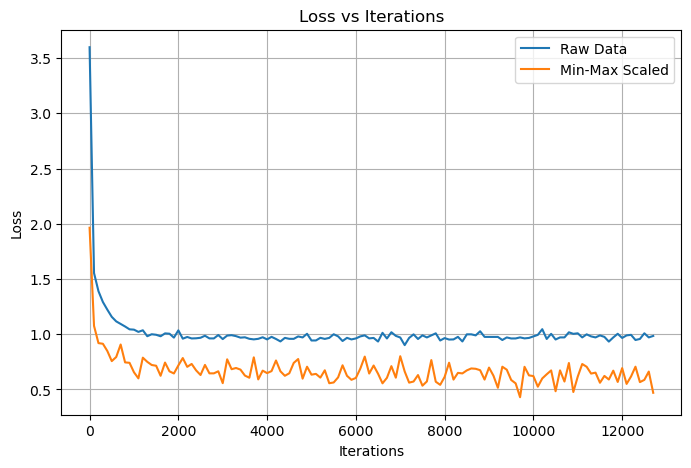

In [73]:
plt.figure(figsize=(8,5))
plt.plot(iter_hist_raw, loss_raw, label="Raw Data")
plt.plot(iter_hist_scaled, loss_scaled, label="Min-Max Scaled")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss vs Iterations")
plt.legend()
plt.grid()
plt.show()

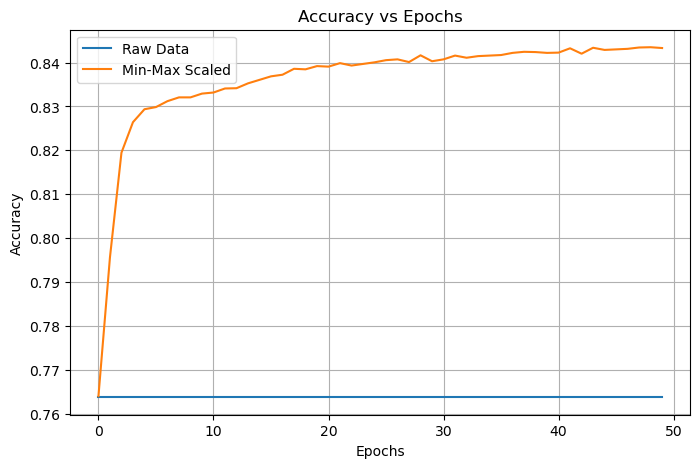

In [74]:
plt.figure(figsize=(8,5))
plt.plot(acc_raw, label="Raw Data")
plt.plot(acc_scaled, label="Min-Max Scaled")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.legend()
plt.grid()
plt.show()